# Train A Shape Classifier Model



In [47]:
import json
import os
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import random

train_data_root = "../datasets/train"
test_data_root = "../datasets/test"

In [53]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import sklearn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import precision_recall_fscore_support
import os

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transformations (including resizing and normalization)
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1), # !! convert to grayscale
    transforms.Resize((64, 64)),  # Resize images to 64x64 pixels
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize the images (mean=0.5, std=0.5 for grayscale)
])

# Load the dataset
train_dataset = datasets.ImageFolder(root=train_data_root, transform=transform)
test_dataset = datasets.ImageFolder(root=test_data_root, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Check class names (optional)
print(f'Classes: {train_dataset.classes}')

# 2. Define a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1) # !! will need to change input channel of conv2
        self.fc1 = nn.Linear(32 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 3)  # 3 classes: circle, triangle, rectangle
        
    def forward(self, x):
        x = F.relu(self.conv1(x))   # First Conv Layer
        x = F.max_pool2d(x, 2)      # Max Pooling
        x = F.relu(self.conv2(x))   # Second Conv Layer
        x = F.max_pool2d(x, 2)      # Max Pooling
        x = x.view(x.size(0), -1)   # Flatten
        x = F.relu(self.fc1(x))     # Fully Connected Layer 1
        x = self.fc2(x)             # Fully Connected Layer 2 (output)
        return x

model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_model(model, train_loader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        accuracy = 100 * correct / total # !! fix this
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {accuracy:.2f}%')


Classes: ['circle', 'diamond', 'triangle']


# Train

In [54]:
train_model(model, train_loader, criterion, optimizer, epochs=15)

Epoch [1/15], Loss: 1.1118, Accuracy: 37.14%
Epoch [2/15], Loss: 1.0345, Accuracy: 43.43%
Epoch [3/15], Loss: 0.9290, Accuracy: 55.14%
Epoch [4/15], Loss: 0.8045, Accuracy: 63.57%
Epoch [5/15], Loss: 0.6507, Accuracy: 74.71%
Epoch [6/15], Loss: 0.4715, Accuracy: 83.00%
Epoch [7/15], Loss: 0.3033, Accuracy: 89.00%
Epoch [8/15], Loss: 0.2110, Accuracy: 94.57%
Epoch [9/15], Loss: 0.1594, Accuracy: 95.00%
Epoch [10/15], Loss: 0.1212, Accuracy: 96.14%
Epoch [11/15], Loss: 0.0832, Accuracy: 97.57%
Epoch [12/15], Loss: 0.0547, Accuracy: 98.86%
Epoch [13/15], Loss: 0.0370, Accuracy: 99.00%
Epoch [14/15], Loss: 0.0288, Accuracy: 99.57%
Epoch [15/15], Loss: 0.0218, Accuracy: 100.00%


# Test 

In [61]:
def test(model, test_loader, device):
    """Print the Precision, Recall and F1-score for the trained model
    """

    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    precision, recall, f1_score, _ = precision_recall_fscore_support(all_labels, all_predictions, average='weighted')

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1_score:.4f}")

test (model, test_loader, device)


Precision: 0.7735
Recall: 0.7733
F1 Score: 0.7734


# Show Predictions


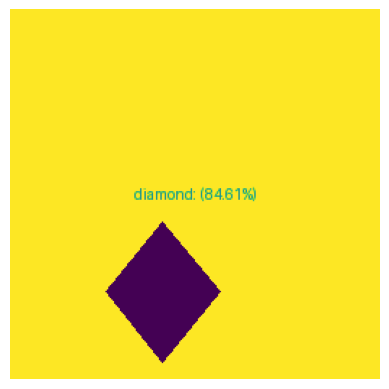

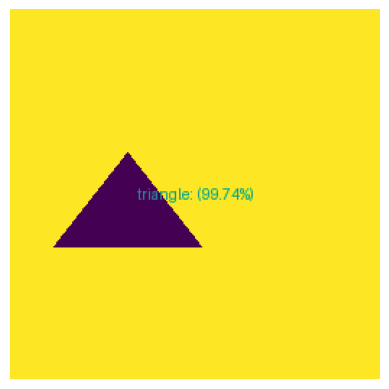

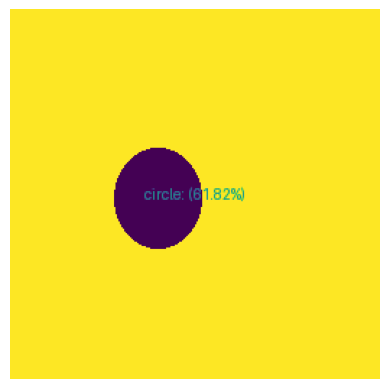

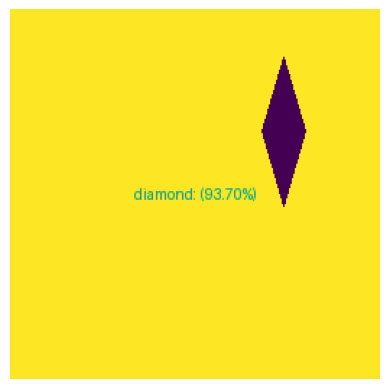

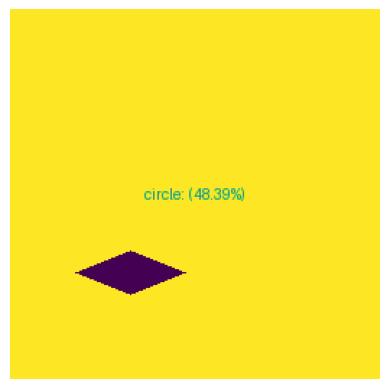

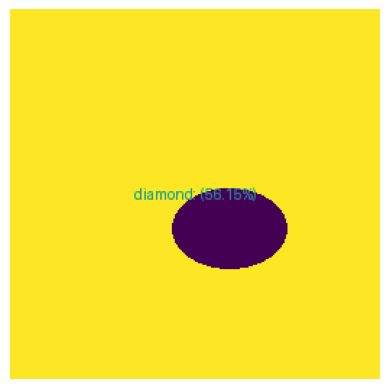

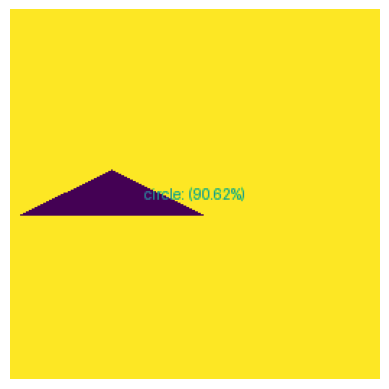

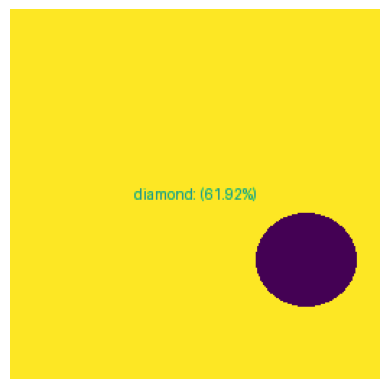

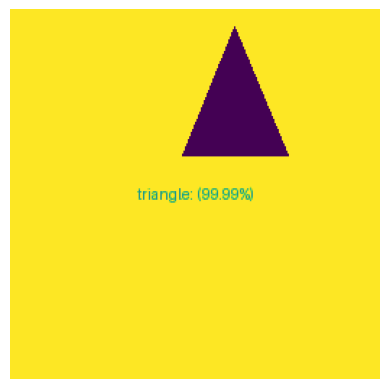

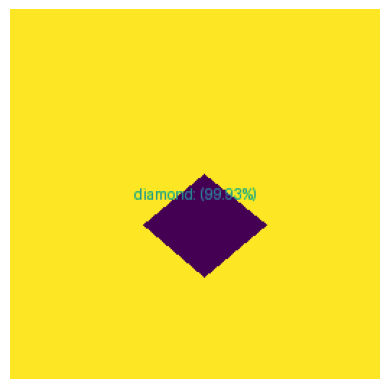

In [67]:
def show_prediction(model, image_path, device):
    """Pass the image to the model and overlay the predicted shape and confidence on the input
    image and display it
    """

    image = Image.open(image_path)
    
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1), # !! convert to grayscale
        transforms.Resize((64, 64)),  # Resize images to 64x64 pixels
        transforms.ToTensor(),  # Convert the image to a tensor
        transforms.Normalize((0.5,), (0.5,))  # Normalize the images (mean=0.5, std=0.5 for grayscale)
    ])

    image_tensor = transform(image).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(image_tensor)

        probabilities = F.softmax(outputs,dim=1) # !! convert the logits from outputs into percentages
        
        confidence, predicted_class = torch.max(probabilities, 1)

    class_names = ['circle', 'diamond', 'triangle']
    predicted_label = class_names[predicted_class.item()]
    confidence_score = confidence.item()

    W, H = image.size # find real display width/height
    draw = ImageDraw.Draw(image)
    font = ImageFont.load_default()
    text = f'{predicted_label}: ({confidence_score*100:.2f}%)'
    w = draw.textlength(text)
    h = 12
    draw.text(((W-w)/2,(H-h)/2), text, fill="gray")

    plt.imshow(image)
    plt.axis('off')
    plt.show()

test_images = test_dataset.imgs
n_images = 10
random_images = random.sample(test_images, n_images)

for image_path, label in random_images:
    show_prediction(model, image_path, device)
        

    